# Part 1. Data extraction
Extract data from .tfrecord format to use with pyTorch.


Mount gDrive to extract data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TFRecord reader for PyTorch - https://github.com/vahidk/tfrecord

In [2]:
! pip install tfrecord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torch.nn as nn
from torchvision import transforms

import matplotlib.pyplot as plt
from matplotlib import colors

from typing import Tuple

torch.manual_seed(42)

## Load dataset

Import data from multiple TFRecord files

In [4]:
from tfrecord.torch.dataset import MultiTFRecordDataset

train_pattern = "/content/drive/MyDrive/archive/next_day_wildfire_spread_train{}.tfrecord"
train_splits = {
    "_00": 0.06,
    "_01": 0.06,
    "_02": 0.06,
    "_03": 0.06,
    "_04": 0.06,
    "_05": 0.06,
    "_06": 0.06,
    "_07": 0.06,
    "_08": 0.06,
    "_09": 0.06,
    "_10": 0.06,
    "_11": 0.06,
    "_12": 0.06,
    "_13": 0.06,
    "_14": 0.06}

eval_pattern = "/content/drive/MyDrive/archive/next_day_wildfire_spread_eval{}.tfrecord"
eval_splits = {
    "_00": 0.5,
    "_01": 0.5}

test_pattern = "/content/drive/MyDrive/archive/next_day_wildfire_spread_test{}.tfrecord"
test_splits = {
    "_00": 0.5,
    "_01": 0.5}

## Configure size and save

In [5]:
train_dataset = MultiTFRecordDataset(train_pattern, index_pattern = None, splits = train_splits)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=14)

In [6]:
eval_dataset = MultiTFRecordDataset(eval_pattern, index_pattern = None, splits = eval_splits)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=2)

In [7]:
test_dataset = MultiTFRecordDataset(test_pattern, index_pattern = None, splits = test_splits)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2)

In [8]:
train_data = next(iter(train_loader))
validation_data = next(iter(eval_loader))
test_data = next(iter(test_loader))

In [9]:
torch.save(train_data, 'train_data.pt')
torch.save(validation_data, 'eval_data.pt')
torch.save(test_data, 'test_data.pt')

In [10]:
train_data = torch.load('train_data.pt')
val_data = torch.load('eval_data.pt')
test_data = torch.load('test_data.pt')

# Part 2. Data Visualisation

## Data preprocessing

In [13]:
from constants import INPUT_FEATURES, OUTPUT_FEATURES
from preprocessdata import clip_and_normalize, random_crop_input_and_output_images


class WildfireDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset['FireMask'])

    def __getitem__(self, index):

        # clip all data to avoid extreme values, (unreasonable, spanning an extensive dynamic range).
        # The clipping values are either based on physical knowledge or set to the 0.1% and 99.9% percentiles.
        # Means and standard deviations are calculated after clipping.

         x = [clip_and_normalize(self.dataset.get(key), key) for key in INPUT_FEATURES]
         x = [feature[index] for feature in x] # 12 x 64 x 64, list of Tensors

         y = [clip_and_normalize(self.dataset.get(key).reshape(-1, 64, 64), key) for key in OUTPUT_FEATURES]
         # y = [self.dataset.get(key).reshape(64, 64) for key in OUTPUT_FEATURES]
         y = y[0][index].reshape((-1, 64,64)) #1 x H x W, Tensor      
         y = y.type(torch.int32) 
         y[y < 0] = 0
         
         inputs_stacked = torch.stack(x, dim = 0) # num_channels x H x W, Tensor
         
         if self.transform:
            input_img, output_img = random_crop_input_and_output_images(inputs_stacked, y, sample_size, num_in_channels, 1)
            return input_img, output_img

         return inputs_stacked, y

In [14]:
# new_data[number of sample][input or output][input-feature/output-mask]
train_dataset = WildfireDataset(train_data, transform = False)
eval_dataset = WildfireDataset(val_data, transform = False)

In [15]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([12, 64, 64])
torch.Size([1, 64, 64])


In [16]:
print(eval_dataset[0][0].shape)
print(eval_dataset[0][1].shape)

torch.Size([12, 64, 64])
torch.Size([1, 64, 64])


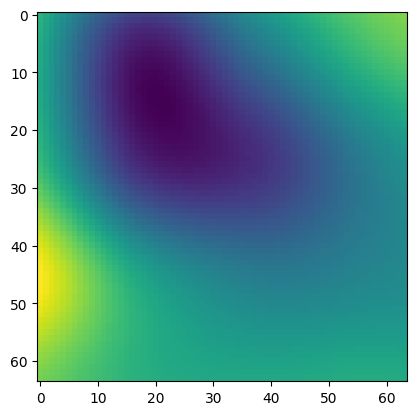

In [17]:
SIZE = 64
plt.imshow(train_dataset[5][0][10].reshape((SIZE, SIZE)))

# Show data

In [18]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [19]:
# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = len(INPUT_FEATURES)
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

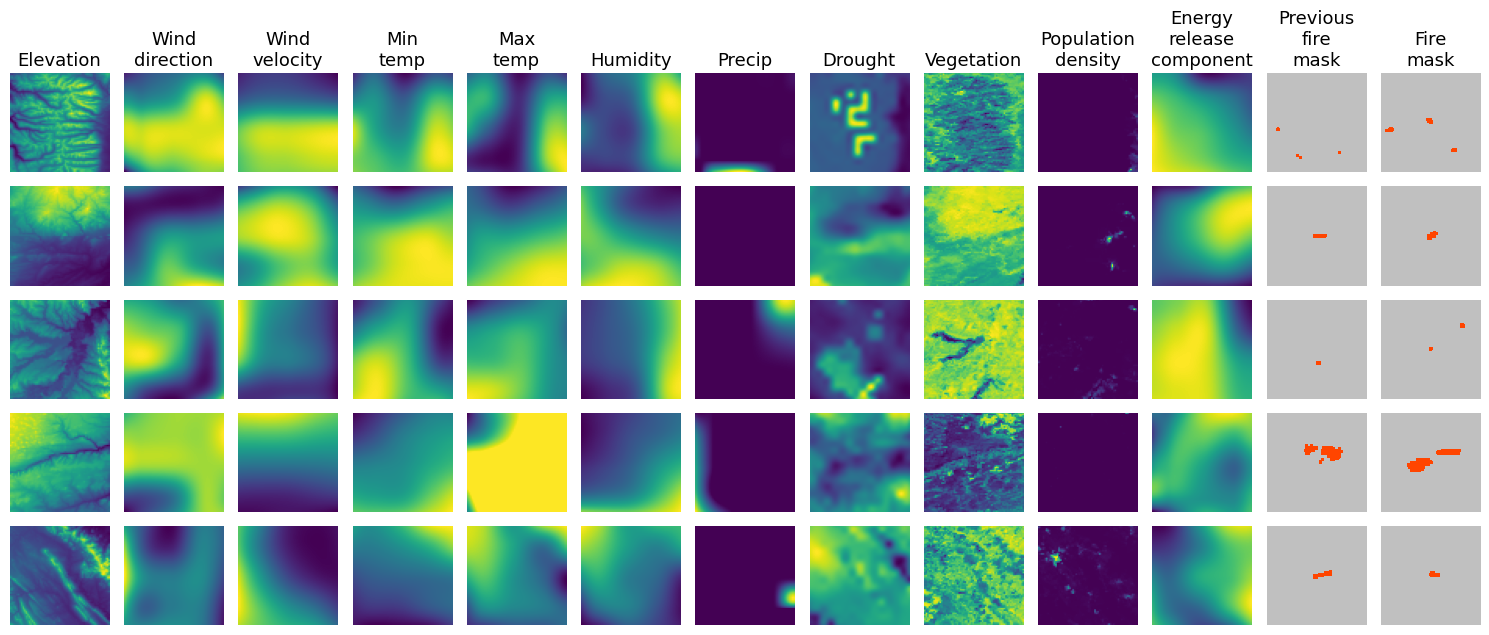

In [20]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features+1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(train_dataset[i][0][j, :, :], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(train_dataset[i][0][-1, :, :], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(train_dataset[i][1][0, :, :], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()
